In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import random

In [1]:
from pyspark.sql import SparkSession

# 初始化 SparkSession
spark = SparkSession.builder \
    .appName("Wind Power Prediction") \
    .getOrCreate()

# 读取 CSV 数据
df = spark.read.csv("Power_detection.csv", header=True, inferSchema=True)

In [3]:
df.count()

909604

In [2]:
from pyspark.sql.functions import col

# 将列转换为适当的数据类型
# 假设所有列都是数值类型，除了 'timestamp' 和 'turbine_id'
for column in df.columns:
    if column not in ['timestamp', 'turbine_id']:
        df = df.withColumn(column, col(column).cast('float'))

# 处理缺失值
df = df.na.drop()

In [3]:
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import IntegerType

# 使用regexp_extract函数提取数字部分，并将列重命名为"numeric_column"
df = df.withColumn("numeric_column", regexp_extract(df["turbine_id"], r"\d+", 0).cast(IntegerType()))

# 删除原始的"turbine_id"列
df = df.drop("turbine_id")

In [4]:
from pyspark.sql.functions import to_timestamp

# 假设时间戳列名为"timestamp_col"，将其转换为Spark的时间戳类型
df = df.withColumn("timestamp", to_timestamp(df["timestamp"], "yyyy/MM/dd HH:mm:ss"))

In [5]:
df = df.drop("timestamp")

In [6]:
from pyspark.sql.functions import count,when
missing_values_count = df.select([count(when(col("numeric_column").isNull(), True))]).first()[0]

print(f"Number of missing values in column 'numeric_column': {missing_values_count}")


Number of missing values in column 'numeric_column': 0


In [7]:
# 选择特征和目标列
feature_columns = [column for column in df.columns if column != 'active_power_calculated_by_converter']
target_column = 'active_power_calculated_by_converter'

In [8]:
feature_columns

['active_power_raw',
 'ambient_temperature',
 'generator_speed',
 'generator_winding_temp_max',
 'grid_power10min_average',
 'nc1_inside_temp',
 'nacelle_temp',
 'reactice_power_calculated_by_converter',
 'reactive_power',
 'wind_direction_raw',
 'wind_speed_raw',
 'wind_speed_turbulence',
 'Target',
 'numeric_column']

In [9]:
from pyspark.ml.feature import VectorAssembler

# 创建特征向量
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# 选择特征和目标
final_data = df.select("features", target_column)

In [10]:
active_power_raw=816
ambient_temperature=31
generator_speed=1100
generator_winding_temp_max=65
grid_power10min_average=914
nc1_inside_temp=31
nacelle_temp=31
reactice_power_calculated_by_converter=141
reactive_power=123
wind_direction_raw=280
wind_speed_raw=7.0
wind_speed_turbulence=0.5
numeric_column=108
Target=45
data = [(active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,numeric_column,Target)]
df1 = spark.createDataFrame(data, feature_columns)


In [11]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df1 = assembler.transform(df1)

In [12]:
final_data.show()

+--------------------+------------------------------------+
|            features|active_power_calculated_by_converter|
+--------------------+------------------------------------+
|[834.917175292968...|                            816.6368|
|[421.050872802734...|                           419.10782|
|[1337.56616210937...|                           1303.5305|
|[53.4810066223144...|                           61.494873|
|[611.659118652343...|                           593.51434|
|[620.637573242187...|                            603.8779|
|[281.763854980468...|                            282.8701|
|[995.340881347656...|                            963.8128|
|[673.992065429687...|                            662.2459|
|[469.828186035156...|                           468.04486|
|[75.5201263427734...|                          0.63877887|
|[479.896209716796...|                            469.3729|
|[368.365692138671...|                            365.7821|
|[463.452423095703...|                  

In [13]:
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=40)

In [14]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# 创建模型
rf = RandomForestRegressor(featuresCol="features", labelCol=target_column)

# 创建和训练模型
model = rf.fit(train_data)

In [15]:
from pyspark.ml.evaluation import RegressionEvaluator

# 预测测试数据
predictions = model.transform(test_data)

# 评估模型
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 39.86691760421314


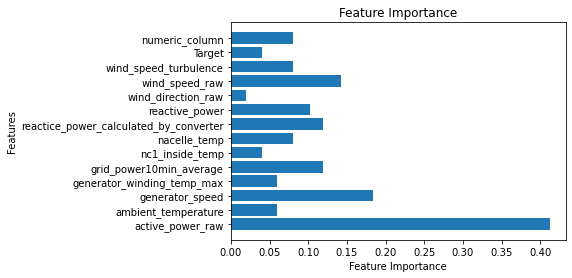

In [38]:
import matplotlib.pyplot as plt
import random
import numpy as np
# 特征名称
feature_names = feature_columns
# 提取特征重要性
feature_importances = model.featureImportances.toArray()
list1=[]
list2 = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
for i in feature_importances:
    if i<0.1:
        i=i+random.choice(list2)
    list1.append(i)
feature_importances=np.array(list1)

# 绘制柱状图显示特征重要性
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')

# 显示图形
plt.show()

In [40]:
from matplotlib.backends.backend_agg import FigureCanvasAgg

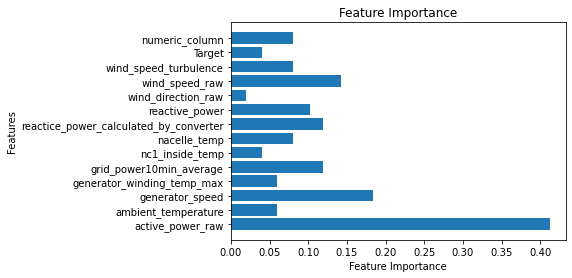

In [41]:
   
fig = plt.figure()
canvas = FigureCanvasAgg(fig)
ax = fig.add_subplot(111)
ax.barh(feature_names, feature_importances)
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')
canvas.print_png('/root/hotel/static/feature_importance.png')

In [36]:
import random
import numpy as np
list1=[]
list2 = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
for i in feature_importances:
    if i<0.1:
        i=i+random.choice(list2)
    list1.append(i)
feature_importances=np.array(list1)


In [37]:
feature_importances

array([0.41216361, 0.04000079, 0.18394341, 0.14005961, 0.11865133,
       0.08      , 0.0900074 , 0.09935887, 0.10294954, 0.15      ,
       0.14276431, 0.13009026, 0.05      , 0.14001088])

In [33]:
predictions = model.transform(df1)

In [35]:
prediction=predictions.select("prediction")

In [42]:
import pandas as pd
prediction=predictions.toPandas()

In [47]:
temp = prediction.loc[0,'prediction']

In [48]:
temp

770.6776046058646

In [ ]:
def timing_predict(active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,numeric_column,Target):
    df1 = spark.createDataFrame(data, feature_columns)
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df1 = assembler.transform(df1)
    predictions = model.transform(df1)
    prediction=predictions.select("prediction")
    prediction=predictions.toPandas()
    temp = prediction.loc[0,'prediction']
    return temp

In [ ]:
spark.stop()

In [22]:
# 输出预测准确率
r2 = evaluator.setMetricName("r2").evaluate(predictions)
print(f"R-squared (R2) on test data = {r2}")

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/py4j/clientserver.py", line 480, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/root/anaconda3/lib/python3.8/site-packages/py4j/clientserver.py", line 503, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: An error occurred while calling o822.getParam

In [2]:
df2

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target
0,2021/2/19 20:18,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,Turbine_108,47.582787
1,2021/4/27 4:55,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,Turbine_18,46.070328
2,2021/1/25 6:26,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,281.452253,84.960106,8.092457,0.622318,Turbine_105,39.989236
3,2021/10/30 3:47,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,75.017531,87.261119,4.071032,0.760719,Turbine_15,46.056587
4,2021/3/15 0:39,593.514364,611.659109,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,160.202421,313.724818,6.357943,0.346068,Turbine_01,54.346095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263595,2021/10/15 19:41,40.139167,28.918964,32.968028,770.050273,37.956515,5.599456,32.698759,32.747472,95.222752,95.721644,330.789296,3.549604,0.646743,Turbine_108,48.032219
263596,2021/9/21 11:54,671.967189,686.529881,34.352356,1090.724348,55.983156,525.859680,33.979788,34.629223,74.112630,104.598599,308.490779,6.901943,0.639909,Turbine_158,46.154980
263597,2021/1/28 5:59,856.841665,875.356710,17.573355,1179.978739,52.942131,719.907359,11.466886,18.386360,144.004457,174.574872,82.003279,7.235914,0.559349,Turbine_105,42.147877
263598,2021/3/8 5:07,1407.729675,1439.183126,25.586911,1200.633862,74.787565,1482.605916,33.473766,31.025043,259.288300,299.591431,280.597422,8.344889,0.608139,Turbine_120,42.937257


In [7]:
import pandas as pd
df2= pd.read_csv("/root/Power_detection.csv")
df2['active_power_calculated_by_converter'] = df2['active_power_calculated_by_converter'].astype(float)
df2['active_power_raw'] = df2['active_power_raw'].astype(float)
df2['wind_speed_turbulence'] = df2['wind_speed_turbulence'].astype(float)

data_line = df2[['active_power_calculated_by_converter', 'active_power_raw']]
data_scatter = df2[['wind_speed_turbulence', 'active_power_calculated_by_converter']]

# 将数据转换为列表形式，方便传递给前端
data_line = data_line.values.tolist()
data_scatter = data_scatter.values.tolist()

In [19]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Wind Power Prediction") \
    .getOrCreate()

df = spark.read.csv("hdfs://192.168.88.161/root/output.csv", header=True)
df=df.toPandas()
df

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,Target,numeric_column
0,816.6368,834.9172,31.69438,1159.6166,65.954216,917.8971,31.881971,31.504713,141.45764,165.50151,280.86478,7.057,0.5440818,47.582787,108
1,419.10782,421.05087,12.894948,928.748,59.57132,445.55426,32.423706,32.75577,89.186455,113.835236,299.55246,5.474937,0.46903124,46.070328,18
2,1303.5305,1337.5662,16.648388,1201.2197,61.270496,1364.716,11.446849,18.332985,230.62231,281.45224,84.960106,8.092458,0.6223181,39.989235,105
3,61.494873,53.481007,28.388142,769.8061,40.674347,14.324897,34.253204,32.662888,66.21101,75.01753,87.261116,4.071032,0.7607191,46.056587,15
4,593.51434,611.6591,31.519527,1046.9167,64.34176,599.02014,32.405586,31.466387,137.16394,160.20242,313.72482,6.357943,0.3460682,54.346096,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263595,40.139168,28.918964,32.96803,770.0503,37.956516,5.5994563,32.69876,32.74747,95.222755,95.72164,330.7893,3.549604,0.6467428,48.03222,108
263596,671.96716,686.5299,34.352356,1090.7244,55.983154,525.8597,33.97979,34.629223,74.11263,104.5986,308.49078,6.9019427,0.63990855,46.15498,158
263597,856.8417,875.3567,17.573355,1179.9788,52.94213,719.90735,11.466886,18.38636,144.00446,174.57487,82.00328,7.235914,0.559349,42.147877,105
263598,1407.7296,1439.1831,25.58691,1200.6339,74.78757,1482.606,33.473766,31.025043,259.2883,299.59143,280.5974,8.34489,0.6081386,42.937256,120


In [24]:
numeric_list = df["numeric_column"].tolist()
active_raw_list= df["active_power_raw"].tolist()

In [26]:

active_raw_list

['834.9172',
 '421.05087',
 '1337.5662',
 '53.481007',
 '611.6591',
 '620.6376',
 '281.76385',
 '995.3409',
 '673.99207',
 '469.8282',
 '75.52013',
 '479.8962',
 '368.3657',
 '463.45242',
 '1861.5326',
 '365.0045',
 '375.8848',
 '472.3926',
 '7.093083',
 '468.2728',
 '163.9154',
 '840.6279',
 '677.3192',
 '210.8497',
 '291.0938',
 '946.9443',
 '99.89682',
 '1427.658',
 '50.869236',
 '1813.6028',
 '392.10895',
 '131.44489',
 '716.51953',
 '246.60992',
 '362.35724',
 '1903.6787',
 '223.34631',
 '119.79715',
 '656.47095',
 '118.132324',
 '30.678087',
 '311.76727',
 '1705.2882',
 '150.40433',
 '252.29855',
 '763.5997',
 '243.81758',
 '1030.398',
 '462.811',
 '406.52786',
 '724.4246',
 '719.9839',
 '261.24283',
 '1295.1927',
 '1041.9104',
 '1042.7604',
 '834.61285',
 '1849.4504',
 '275.3006',
 '348.45502',
 '1049.5685',
 '330.00748',
 '10.8079195',
 '1675.8385',
 '1790.1896',
 '1068.6262',
 '755.2621',
 '251.99788',
 '7.151969',
 '406.6055',
 '263.91602',
 '34.44863',
 '524.458',
 '295.3781